In [158]:
import tensorflow as tf
print(tf.version.VERSION)
import matplotlib as mpl

2.2.0


In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Unsupervised Hierarchical Disentanglement for Fine Grained Object Generation.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.version.VERSION.startswith('2.')

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add, dot, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class GLU(tf.keras.layers.Layer):
    def __init__(self):
        super(GLU, self).__init__()

    def call(self, inputs):
        nc = inputs.shape[-1]
        assert nc % 2 == 0, 'Channels are not divisible by 2.'
        nc = int(nc/2)
        if len(inputs.shape) == 2:
            val = inputs[:,:nc] * tf.math.sigmoid(inputs[:,nc:])
        else:
            val = inputs[:,:,:,:nc] * tf.math.sigmoid(inputs[:,:,:,nc:])
        return val
    

class ParentChildEncoder(tf.keras.layers.Layer):
    """Encoder for parent and child images"""
    def __init__(self, num_disc_features, **kwargs):
        super(ParentChildEncoder, self).__init__(**kwargs)
        self.num_disc_features = num_disc_features
        
        self.conv1 = Conv2D(self.num_disc_features, 4, 2, use_bias=False)
        self.conv2 = Conv2D(self.num_disc_features*2, 4, 2, use_bias=False)
        self.batchnorm1 = BatchNormalization()
        self.conv3 = Conv2D(self.num_disc_features*4, 4, 2, use_bias=False)
        self.batchnorm2 = BatchNormalization()
        self.conv4 = Conv2D(self.num_disc_features*8, 4, 2, use_bias=False)
        self.batchnorm3 = BatchNormalization()

    def call(self, inputs):
        x = ZeroPadding2D(1)(inputs)
        x = self.conv1(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = ZeroPadding2D(1)(x)
        x = self.conv4(x)
        x = self.batchnorm3(x)
        return LeakyReLU(alpha=0.2)(x)


class BackgroundEncoder(tf.keras.layers.Layer):
    """Encoder for the background image"""
    def __init__(self, num_disc_features, **kwargs):
        super(BackgroundEncoder, self).__init__(**kwargs)
        self.num_disc_features = num_disc_features
        
        self.conv1 = Conv2D(self.num_disc_features, 4, 2, use_bias=False)
        self.conv2 = Conv2D(self.num_disc_features*2, 4, 2, use_bias=False)
        self.conv3 = Conv2D(self.num_disc_features*4, 4, 1, use_bias=False)
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        x = self.conv2(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = self.conv3(x)
        return LeakyReLU(alpha=0.2)(x)


class UpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(UpSampleBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.upsample1 = Conv2DTranspose(self.filters*2, 3, strides=2, padding='same',
                                         kernel_initializer="orthogonal", use_bias=False)
        self.batchnorm1 = BatchNormalization()

    def call(self, inputs):
        x = self.upsample1(inputs)
        x = self.batchnorm1(x)
        return GLU()(x)


class DownSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(DownSampleBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.conv1 = Conv2D(self.filters, 4, 2, use_bias=False)
        self.batchnorm1 = BatchNormalization()

    def call(self, inputs):
        x = ZeroPadding2D(1)(inputs)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        return LeakyReLU(alpha=0.2)(x)


class KeepDimsBlock(tf.keras.layers.Layer):
    def __init__(self, filters=16, **kwargs):
        super(KeepDimsBlock, self).__init__(**kwargs)
        self.filters = filters
        
        self.conv1 = Conv2D(self.filters*2, 3, kernel_initializer='orthogonal', use_bias=False)
        self.batchnorm1 = BatchNormalization()

    def call(self, inputs):
        x = ZeroPadding2D(1)(inputs)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        return GLU()(x)


class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, channels=16, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.channels = channels
        
        self.conv1 = Conv2D(filters=self.channels * 2, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False)
        self.batchnorm1 = BatchNormalization()
        self.conv2 = Conv2D(filters=self.channels, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False)
        self.batchnorm2 = BatchNormalization()
        
    def call(self, inputs):
        residual = inputs
        x = ZeroPadding2D(1)(inputs)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = GLU()(x)
        x = ZeroPadding2D(1)(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        return tf.keras.layers.Add()([x, residual])


class InitGenerator(tf.keras.Model):
    def __init__(self, cfg, gen_dims, condition_flag, **kwargs):
        super(InitGenerator, self).__init__(**kwargs)
        self.gf_dim = gen_dims
        self.condition_flag = condition_flag

        if self.condition_flag==1 :
            self.input_dims = cfg.GAN['Z_DIM'] + cfg.SUPER_CATEGORIES
        elif self.condition_flag==2:
            self.input_dims = cfg.GAN['Z_DIM'] + cfg.FINE_GRAINED_CATEGORIES 

        self.layer1 = UpSampleBlock(self.gf_dim // 2)
        self.layer2 = UpSampleBlock(self.gf_dim // 4)
        self.layer3 = UpSampleBlock(self.gf_dim // 8)
        self.layer4 = UpSampleBlock(self.gf_dim // 16)
        self.layer5 = UpSampleBlock(self.gf_dim // 16)
        
        self.dense1 = Dense(self.gf_dim*4*4*2, kernel_initializer='orthogonal', use_bias=False)
        self.batchnorm1 = BatchNormalization()

    def call(self, z_code, h_code):
        z_code = tf.cast(z_code, dtype=tf.float32)
        h_code = tf.cast(h_code, dtype=tf.float32)
        x = Concatenate()([z_code, h_code])
        x = self.dense1(x)
        x = self.batchnorm1(x)
        x = GLU()(x)
        x = Reshape((4, 4, self.gf_dim))(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.layer5(x)


class IntermediateGenerator(tf.keras.Model):
    def __init__(self, cfg, gen_dims, hrc=1, num_residual=cfg.GAN['R_NUM'], **kwargs):
        super(IntermediateGenerator, self).__init__(**kwargs)
        self.gf_dim = gen_dims
        self.res = num_residual
        if hrc == 1:
            self.ef_dim = cfg.SUPER_CATEGORIES
        else:
            self.ef_dim = cfg.FINE_GRAINED_CATEGORIES

        self.convblock = Sequential([
            ZeroPadding2D(1),
            Conv2D(self.gf_dim*2, 3, 1, kernel_initializer='orthogonal', use_bias=False),
            BatchNormalization(),
            GLU()
        ])

        self.residual = self.make_layer(ResidualBlock, self.gf_dim)
        self.keepdims = KeepDimsBlock(self.gf_dim // 2)

    def make_layer(self, block, channel_num):
        return Sequential([block(channel_num),
                          block(channel_num)])

    def call(self, h_code, code):
        s_size = h_code.shape[1]
        code = Reshape([1, 1, self.ef_dim])(code)
        code = tf.tile(code, tf.constant([1, s_size, s_size, 1]))
        h_code = tf.cast(h_code, dtype=tf.float32)
        code = tf.cast(code, dtype=tf.float32)
        x = Concatenate(axis=-1)([code, h_code])
        x = self.convblock(x)
        x = self.residual(x)
        return self.keepdims(x)


class GetImage(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GetImage, self).__init__(**kwargs)
        self.out_image = Sequential([
            ZeroPadding2D(1),
            Conv2D(filters=3, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False),
            Activation('tanh')
        ])

    def call(self, inputs):
        return self.out_image(inputs)


class GetMask(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GetMask, self).__init__(**kwargs)
        self.out_mask = Sequential([
            ZeroPadding2D(1),
            Conv2D(filters=1, kernel_size=3, strides=1, kernel_initializer='orthogonal', 
            use_bias=False),
            Activation('sigmoid')
        ])

    def call(self, inputs):
        return self.out_mask(inputs)

    
class GeneratorArchitecture(tf.keras.Model):
    def __init__(self, cfg, **kwargs):
        super(GeneratorArchitecture, self).__init__(**kwargs)
        self.cfg = cfg
        self.gen_dims = cfg.GAN['GF_DIM']
                
        # Background Stage
        self.background_gen = InitGenerator(cfg, self.gen_dims*16, 2)
        self.image_bg = GetImage() # Background Image

        # Parent Stage
        self.parent_gen1 = InitGenerator(cfg, self.gen_dims*16, 1)
        self.parent_gen2 = IntermediateGenerator(cfg, self.gen_dims, 1)
        self.image_gen2 = GetImage() # Parent Foreground
        self.mask_gen2 = GetMask() # Parent Mask

        # Child Stage
        self.child_gen = IntermediateGenerator(cfg, self.gen_dims // 2, 0)
        self.image_child = GetImage() # Child Foreground
        self.mask_child = GetMask() # Child Mask

    def call(self, z_code, c_code, p_code=None, bg_code=None):
        fake_images = [] # [Background images, Parent images, Child images]
        foreground_images = [] # [Parent foreground, Child foreground]
        masks = [] # [Parent masks, Child masks]
        foreground_masks = [] # [Parent foreground mask, Child foreground mask]

        # Set only during training
        bg_code = tf.cast(c_code, dtype=tf.float32)

        # Background Stage
        bg_stage_code = self.background_gen(z_code, bg_code) # Upsampled Background
        fake_bg = self.image_bg(bg_stage_code)
        fake_img_126 = tf.image.resize(fake_bg,(126, 126))
        fake_images.append(fake_img_126)

        # Parent Stage
        fp_dims = self.parent_gen1(z_code, p_code)
        p_dims = self.parent_gen2(fp_dims, p_code) # Feature Representation (F_p)
        fake_parent_fg = self.image_gen2(p_dims) # Parent Foreground (P_f)
        fake_parent_mask = self.mask_gen2(p_dims) # Parent Mask (P_m)
        inverse_ones = tf.ones_like(fake_parent_mask)
        inverse_mask = inverse_ones - fake_parent_mask # (1-P_m)
        parent_foreground_mask = tf.math.multiply(fake_parent_fg, fake_parent_mask) # Parent Foreground Mask (P_fm)
        background_mask = tf.math.multiply(fake_bg, inverse_mask) # Background Mask (B_m)
        fake_parent_image = parent_foreground_mask + background_mask # Parent Image (P)
        fake_images.append(fake_parent_image)
        foreground_images.append(fake_parent_fg)
        masks.append(fake_parent_mask)
        foreground_masks.append(parent_foreground_mask)

        # Child Stage
        # TODO: Test whether inclusion of the ResidualGen is necessary
        fc_dims = self.child_gen(p_dims, c_code)
        fake_child_fg = self.image_child(fc_dims) # Child Foreground (C_f)
        fake_child_mask = self.mask_child(fc_dims) # Child Mask (C_m)
        inverse_ones = tf.ones_like(fake_child_mask)
        inverse_mask = inverse_ones - fake_child_mask # (1-C_m)
        child_foreground_mask = tf.math.multiply(fake_child_fg, fake_child_mask) # Child Foreground mask (C_fm)
        child_parent_mask = tf.math.multiply(fake_parent_image, inverse_mask) # Parent Mask (P_m)
        fake_child_image = child_foreground_mask + child_parent_mask # Child Image (C)
        fake_images.append(fake_child_image)
        foreground_images.append(fake_child_fg)
        masks.append(fake_child_mask)
        foreground_masks.append(child_foreground_mask)

        return fake_images, foreground_images, masks, foreground_masks       


class DiscriminatorArchitecture(tf.keras.Model):
    def __init__(self, cfg, stage_num, **kwargs):
        super(DiscriminatorArchitecture, self).__init__(**kwargs)
        self.disc_dims = cfg.GAN['DF_DIM']
        self.stage_num = stage_num

        if self.stage_num == 0:
            self.encoder_dims = 1
        elif self.stage_num == 1:
            self.encoder_dims = cfg.SUPER_CATEGORIES
        elif self.stage_num == 2:
            self.encoder_dims = cfg.FINE_GRAINED_CATEGORIES

        if self.stage_num == 0:
            # Background Stage
            self.patchgan_16 = BackgroundEncoder(self.disc_dims)
            self.logits1 = Sequential([
                Conv2D(1, 4, 1),
                Activation('sigmoid')  
            ])
            self.logits2 = Sequential([
                Conv2D(1, 4, 1),
                Activation('sigmoid')
            ])

        else:
            self.code_16 = ParentChildEncoder(self.disc_dims)
            self.code_32 = DownSampleBlock(self.disc_dims*16)
            self.code = Sequential([
                ZeroPadding2D(1),
                Conv2D(self.disc_dims*8, 3, kernel_initializer='orthogonal', use_bias=False),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ])
            # Pass gradients through
            self.logits_pc = Sequential([
                Conv2D(self.encoder_dims, 4, 4, name=f'logits_pc_{self.stage_num}')
            ])
            # Pass gradients through
            self.jointConv = Sequential([
                ZeroPadding2D(1),
                Conv2D(self.disc_dims*8, 3, kernel_initializer='orthogonal', use_bias=False, name=f'joint_conv_{self.stage_num}'),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ])
            self.logits_pc1 = Sequential([
                Conv2D(1, 4, 4, use_bias=False),
                Activation('sigmoid')
            ])


    def call(self, inputs):
        if self.stage_num == 0:
            x = self.patchgan_16(inputs)
            back_fore = self.logits1(x) # Background/Foreground classification (D_aux)
            real_fake = self.logits2(x) # Real/Fake classification (D_adv)
            return [back_fore, real_fake]
            
        else:
            x = self.code_16(inputs)
            x = self.code_32(x)
            x = self.code(x)
            x = self.jointConv(x)
            p_c = self.logits_pc(x) # Information maximising code (D_pinfo or D_cinfo)
            real_fake_child = self.logits_pc1(x) # Real/Fake classification - child (D_adv)
            return [Reshape([self.encoder_dims])(p_c), Reshape([-1])(real_fake_child)]

In [425]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Trains the FineGAN Model for Fine Grained Object Generation and Discovery.
"""

import os
import time
import PIL
import pickle
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
assert tf.version.VERSION.startswith('2.')

# from model import GeneratorArchitecture, DiscriminatorArchitecture
# from model import child_to_parent
from config.config import Config

AUTOTUNE = tf.data.experimental.AUTOTUNE

def save_images(imgs_tcpu, fake_imgs, epoch):
    num = cfg.TRAIN['VIS_COUNT']
    real_img = imgs_tcpu[-1][0:num]

    image = plt.figure()
    ax = image.add_subplot(1,1,1)
    ax.imshow(real_img[0])
    ax.axis("off")
    plt.savefig(f'test/{epoch}_real_sample.png')

    for i in range(len(fake_imgs)):
        fake_img = fake_imgs[i][0:num]

        image = plt.figure()
        ax = image.add_subplot(1,1,1)
        ax.imshow(fake_img)
        ax.axis("off")
        plt.savefig(f'test/{epoch}_fake_sample_{i}.png')


def normalize(input_image):
    input_image = np.array(input_image)
    input_image = (input_image / 127.5) - 1.
    return input_image


def load_class_ids_filenames(class_id_path, filename_path):
    with open(class_id_path, 'rb') as file:
        class_id = pickle.load(file, encoding='latin1')

    with open(filename_path, 'rb') as file:
        filename = pickle.load(file, encoding='latin1')

    return class_id, filename


def load_bbox(data_path='../../CUB data/CUB_200_2011'):
    bbox_path = data_path + '/bounding_boxes.txt'
    image_path = data_path + '/images.txt'

    bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
    filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

    filenames = filename_df[1].tolist()
    bbox_dict = {i[:-4]:[] for i in filenames[:2]}

    for i in range(0, len(filenames)):
        bbox = bbox_df.iloc[i][1:].tolist()
        dict_key = filenames[i][:-4]
        bbox_dict[dict_key] = bbox

    return bbox_dict


def load_images(image_path, bounding_box, size):
    """Crops the image to the bounding box and then resizes it.
    """
    base_size=64

    imsize = []
    for _ in range(3):
        imsize.append(base_size)
        base_size *= 2

    image = Image.open(image_path).convert('RGB')

    w, h = image.size

    if bounding_box is not None:
        r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
        c_x = int((bounding_box[0] + bounding_box[2]) / 2)
        c_y = int((bounding_box[1] + bounding_box[3]) / 2)
        y1 = np.maximum(0, c_y - r)
        y2 = np.minimum(h, c_y + r)
        x1 = np.maximum(0, c_x - r)
        x2 = np.minimum(w, c_x + r)
        fimg = image.copy()
        fimg_arr = np.array(fimg)
        fimg = Image.fromarray(fimg_arr)
        cimg = image.crop([x1, y1, x2, y2])
        
    re_cimg = cimg.resize([imsize[1], imsize[1]])
        
    re_fimg = fimg.resize([int(126 * 76/64), int(126 * 76/64)])
    re_w, re_h = re_fimg.size
    
    x_crop = re_w - 126
    y_crop = re_h - 126
    
    # Return cropped image
    cropped_re_fimg = re_fimg.crop([x_crop, y_crop, x_crop+126, y_crop+126])
    
    mod_x1 = bounding_box[0] * re_w / w
    mod_y1 = bounding_box[1] * re_h / h
    mod_x2 = mod_x1 + (bounding_box[2] * re_w / w)
    mod_y2 = mod_y1 + (bounding_box[3] * re_h / h)
    
    mod_x1 = min(max(0, mod_x1 - x_crop), 126)
    mod_y1 = min(max(0, mod_y1 - y_crop), 126)
    mod_x2 = max(min(126, mod_x2 - x_crop),0)
    mod_y2 = max(min(126, mod_y2 - y_crop),0)

    random_flag = np.random.randint(2)
    if(random_flag == 0):
        cropped_re_fimg = cropped_re_fimg.transpose(Image.FLIP_LEFT_RIGHT)
        flipped_x1 = 126 - mod_x2
        flipped_x2 = 126 - mod_x1
        mod_x1 = flipped_x1
        mod_x2 = flipped_x2
    
    modified_bbox = []
    modified_bbox.append(mod_y1)
    modified_bbox.append(mod_x1)
    modified_bbox.append(mod_y2)
    modified_bbox.append(mod_x2)

    return cropped_re_fimg, re_cimg, modified_bbox


def load_data(filename_path, class_id_path, dataset_path, size):
    """Loads the Dataset.
    """
    class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
    bbox_dict = load_bbox(dataset_path)

    fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = [], [], [], [], []

    for _, filename in enumerate(filenames):
        bbox = bbox_dict[filename]

        try:
            image_path = f'{dataset_path}/images/{filename}.jpg'
            fimgs, cimgs, mod_bbox = load_images(image_path, bbox, size)

            rand_class = list(np.random.choice(range(200), 1))
            child_code = np.zeros([200,])
            child_code[rand_class] = 1

            fimgs_list.append(normalize(fimgs))
            cimgs_list.append(normalize(np.asarray(cimgs)))
            child_code_list.append(child_code)
            key_list.append(filename)
            mod_bbox_list.append(mod_bbox)

        except Exception as e:
            print(f'{e}')

    fimgs_list = np.array(fimgs_list)
    cimgs_list = np.array(cimgs_list)
    child_code_list = np.array(child_code_list)
    key_list = np.array(key_list)
    mod_bbox_list = np.array(mod_bbox_list)

    return (fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list)


def load_finegan_network(cfg):
    generator = GeneratorArchitecture(cfg)
    print(f'[INFO] Initialized Generator...')
    
    discriminators = []
    for i in range(3): # 3 discriminators for background, parent and child stage
        discriminators.append(DiscriminatorArchitecture(cfg, i))
    print(f'[INFO] Initialized Discriminators...')
        
    start_epoch = 0    
    return generator, discriminators, len(discriminators), start_epoch


def define_optimizers(gen, disc):   
    optimizers_disc = []
    num_disc = len(disc)
    
    for i in range(3):      
        opt = tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['DISCRIMINATOR_LR'], beta_1=0.5, beta_2=0.999)
        optimizers_disc.append(opt)

    optimizers_gen = []
    optimizers_gen.append(tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['GENERATOR_LR'], beta_1=0.5, beta_2=0.999))

    for i in range(1,3):
        optimizers_gen.append(tf.keras.optimizers.Adam(learning_rate=cfg.TRAIN['GENERATOR_LR'], beta_1=0.5, beta_2=0.999))

    return optimizers_gen, optimizers_disc


def casting_func(fimg, cimg, child_code, mod_bbox):
    fimg = tf.cast(fimg, dtype=tf.float32)
    cimg = tf.cast(cimg, dtype=tf.float32)
    child_code = tf.cast(child_code, dtype=tf.float32)
    mod_bbox = tf.cast(mod_bbox, dtype=tf.float32)
    return fimg, cimg, child_code, mod_bbox


class FineGAN(object):
    """The FineGAN Architecture"""
    def __init__(self, cfg, img_path, train_dataset, **kwargs):
        super(FineGAN, self).__init__(**kwargs)
        self.batch_size = cfg.TRAIN['BATCH_SIZE']
        self.num_epochs = cfg.TRAIN['MAX_EPOCH']
        self.data_dir = img_path
        self.train_dataset = train_dataset
        self.num_disc = 3
        
        self.num_batches = int(train_dataset[0].shape[0] / self.batch_size)

    def plot_images(self, images, num_cols=None):
        num_cols = num_cols or len(images)
        num_rows = (len(images) - 1) // num_cols + 1
        if images.shape[-1] == 1:
            images = np.squeeze(images, axis=-1)
        plt.figure(figsize=(num_cols, num_rows))
        for index, image in enumerate(images):
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(image)
            plt.axis("off")
    
    
    @tf.function
    def train_generator(self):
        generator_error = 0.0
        loss1, class_loss, c_code, parent_code = self.loss1, self.class_loss, self.c_code, self.parent_code

        with tf.GradientTape(persistent=True) as tape:
            
            z_dims = cfg.GAN['Z_DIM']
            noise = tf.random.normal(shape=(self.batch_size, z_dims))
            self.fake_images, self.foreground_images, self.mask_images, self.foreground_masks = self.generator(noise, self.c_code, p_code=parent_code)
            
            for i in range(self.num_disc):
                outputs = self.discriminators[i](self.fake_images[i])

                if i==0 or i==2:
                    real_labels = tf.ones_like(outputs[1])
                    gen_loss = loss1(real_labels, outputs[1])

                    if i==0:
                        gen_loss *= cfg.TRAIN['BG_LOSS_WT']
                        # Background/Foreground classification loss for the fake background
                        gen_class = loss1(real_labels, outputs[0])
                        gen_loss += gen_class

                    generator_error += gen_loss
                
                if i==1:
                    # Information maximizing loss for parent stage
                    parent_prediction = self.discriminators[1](self.foreground_masks[i-1])                   
                    parent_code = tf.cast(parent_code, dtype=tf.float32)
                    gen_info_loss = class_loss(parent_code, parent_prediction[0])
                    stage_1_info_loss = gen_info_loss * 2
                                        
                elif i==2:
                    # Information maximizing loss for child stage
                    child_prediction = self.discriminators[2](self.foreground_masks[i-1])
                    c_code = tf.cast(c_code, dtype=tf.float32)
                    gen_info_loss = class_loss(c_code, child_prediction[0])
                    stage_2_info_loss = gen_info_loss * 2

                if i>0:
                    generator_error += gen_info_loss

        grads_1 = tape.gradient(generator_error, self.generator.trainable_variables)
        grads_2 = tape.gradient(generator_error, self.discriminators[1].trainable_variables[:-1])
        #grads_gen_2 = tape.gradient(stage_1_info_loss, self.generator.trainable_variables[19:57])
        grads_3 = tape.gradient(generator_error, self.discriminators[2].trainable_variables[-3:-1])
        #grads_gen_3 = tape.gradient(stage_2_info_loss, self.generator.trainable_variables[57:])
        
        for index in range(3):
            if index == 0:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_1, self.generator.trainable_variables))
            elif index == 1:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_2, self.discriminators[index].trainable_variables[:-1]))
                #self.optimizer_gen_list[index].apply_gradients(zip(grads_gen_2, self.generator.trainable_variables[19:57]))
            elif index == 2:
                self.optimizer_gen_list[index].apply_gradients(zip(grads_3, self.discriminators[index].trainable_variables[-3:-1]))
                #self.optimizer_gen_list[index].apply_gradients(zip(grads_gen_3, self.generator.trainable_variables[57:]))

        return generator_error
    

    def train_discriminator(self, stage):
        loss, loss1 = self.loss, self.loss1 # Binary Crossentropy

        if stage==0:
            real_images = self.real_fimages
        elif stage==2:
            real_images = self.real_cimages

        fake_images = self.fake_images[stage]
        real_logits = self.discriminators[stage](real_images)
        
        if stage==2:
            fake_labels = tf.zeros_like(real_logits[1])
            real_labels = tf.ones_like(real_logits[1])
            disc_error = self.disc_step_stage2(stage, real_images, real_labels, fake_images, fake_labels, loss, loss1)
        elif stage==0:
            fake_labels = tf.zeros_like(real_logits[1])
            ext, output = real_logits
            real_labels = tf.ones_like(real_logits[1])
            real_weights = np.ones([self.batch_size, 24, 24, 1])
            
            for i in range(self.batch_size):
                
                bbox = self.bbox[i].numpy()
                x1 =  bbox[0]
                x2 =  bbox[2]
                y1 =  bbox[1]
                y2 =  bbox[3]

                """All the patches in NxN from a1:a2 (along rows) and b1:b2 (along columns) will be masked, 
                and loss will only be computed from remaining members in NxN"""

                a1 = (np.maximum(0.0, np.ceil((x1 - self.receptive_field)/(float(self.patch_stride))))).astype(int)
                a2 = (np.minimum(self.num_out-1, np.floor((self.num_out - 1) - ((126 - self.receptive_field) - x2)/self.patch_stride)) + 1).astype(int)
                b1 = (np.maximum(0.0, np.ceil((y1 - self.receptive_field)/self.patch_stride))).astype(int)
                b2 = (np.minimum(self.num_out-1, np.floor((self.num_out-1) - ((126 - self.receptive_field) - y2)/self.patch_stride)) + 1).astype(int)
                
                if x1 != x2 and y1 != y2:
                    real_weights[i, a1:a2, b1:b2, :] = 0.0
            
            real_weights = tf.cast(real_weights, dtype=tf.float32)
            disc_error = self.disc_step_stage0(stage, real_images, real_labels, fake_images, fake_labels, loss, loss1, real_weights)
        return disc_error
    
        
    @tf.function
    def disc_step_stage0(self, stage, real_images, real_labels, fake_images, fake_labels, loss, loss1, real_weights):
        with tf.GradientTape() as tape:
            real_logits = self.discriminators[stage](real_images)
            fake_logits = self.discriminators[stage](tf.stop_gradient(fake_images))
            ext, output = real_logits

            norm_real = tf.reduce_sum(real_weights)
            norm_fake = self.batch_size * real_weights.shape[1] * real_weights.shape[2] * real_weights.shape[3]
            real_logits = ext, output
        
            error_disc_real = loss(real_labels, real_logits[1])
            error_disc_real = tf.keras.backend.mean(tf.math.multiply(error_disc_real, real_weights))
            error_disc_classification = tf.keras.backend.mean(loss(real_weights, real_logits[0]))
            error_disc_fake = loss(fake_labels, fake_logits[1])
            error_disc_fake = tf.keras.backend.mean(error_disc_fake)

            if norm_real > 0:
                error_real = error_disc_real * ((norm_fake * 1.0) / (norm_real * 1.0))
            else:
                error_real = error_disc_real
            
            error_real = error_disc_real
            error_fake = error_disc_fake
            discriminator_error = ((error_real + error_fake) * cfg.TRAIN['BG_LOSS_WT']) + error_disc_classification

        grads = tape.gradient(discriminator_error, self.discriminators[stage].trainable_variables)
        self.optimizer_disc_list[stage].apply_gradients(zip(grads, self.discriminators[stage].trainable_variables))
        return discriminator_error
    
    
    @tf.function
    def disc_step_stage2(self, stage, real_images, real_labels, fake_images, fake_labels, loss, loss1):
        with tf.GradientTape() as tape:
            real_logits = self.discriminators[stage](real_images)
            fake_logits = self.discriminators[stage](fake_images)
            
            error_real = loss1(real_labels, real_logits[1]) # Real/Fake loss for the real image
            error_fake = loss1(fake_labels, fake_logits[1]) # Real/Fake loss for the fake image   
            discriminator_error = error_real + error_fake

        grads = tape.gradient(discriminator_error, self.discriminators[stage].trainable_variables)
        self.optimizer_disc_list[stage].apply_gradients(zip(grads, self.discriminators[stage].trainable_variables))
        return discriminator_error
        
    
    def train_model(self, start=True):
        self.patch_stride = 4.0 # Receptive field stride for Backround Stage Discriminator 
        self.num_out = 24 # Patch output size in NxN
        
        self.receptive_field = 34 # Receptive field of every patch in NxN

        print(f'[INFO] Starting FineGAN Training...')
        self.generator, self.discriminators, self.num_disc, start_epoch = load_finegan_network(cfg)
        
        if start == False:
            self.generator.load_weights('./Checkpoints/generator_225_epochs.ckpt')
            self.discriminators[0].load_weights('./Checkpoints/discriminator_0_225_epochs.ckpt')
            self.discriminators[1].load_weights('./Checkpoints/discriminator_1_225_epochs.ckpt')
            self.discriminators[2].load_weights('./Checkpoints/discriminator_2_225_epochs.ckpt')
            print(f'[INFO] Loaded FineGAN Weights...')
            print(f'[INFO] Continuing FineGAN Training...')
            
        self.optimizer_gen_list, self.optimizer_disc_list = define_optimizers(self.generator, self.discriminators)

        self.loss = tf.keras.losses.BinaryCrossentropy()
        self.loss1 = tf.keras.losses.BinaryCrossentropy()
        self.class_loss = tf.keras.losses.CategoricalCrossentropy()

        self.real_labels = tf.ones_like(self.batch_size, dtype=tf.float32)
        self.fake_labels = tf.zeros_like(self.batch_size, dtype=tf.float32)
        
        fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = self.train_dataset
        
        data = tf.data.Dataset.from_tensor_slices((fimgs_list, cimgs_list, child_code_list, mod_bbox_list))
        data = data.batch(16)
        data = data.map(lambda fimgs, cimgs, child_code, mod_bbox: casting_func(fimgs, cimgs, child_code, mod_bbox), num_parallel_calls=AUTOTUNE)
        data = data.shuffle(1000).prefetch(2)
                    
        start_epoch = 225
        self.num_epochs = 300
                
        for epoch in range(start_epoch, self.num_epochs):
                
            print(f'[Train] FineGAN Epoch: {epoch+1}/{self.num_epochs}')
            start_time = time.time()
            count = 0
            for i, batch in enumerate(data):
                self.real_fimages, self.real_cimages, self.c_code, self.bbox = batch
                
                if self.c_code.shape[0] != self.batch_size:
                    continue
                                        
                ratio = 10
                child_code = self.c_code.numpy()
                arg_parent = (np.argmax(child_code, axis=1)/int(ratio)).astype(int)
                parent_code = np.zeros([child_code.shape[0], 20])
                
                for i in range(child_code.shape[0]):
                    parent_code[i][arg_parent[i]] = 1
                
                parent_code = tf.Variable(parent_code)
                self.parent_code = tf.cast(parent_code, dtype=tf.float32)
                                
                z_dims = cfg.GAN['Z_DIM']
                noise = tf.random.normal(shape=(self.batch_size, z_dims))
                self.fake_images, self.foreground_images, self.mask_images, self.foreground_masks = self.generator(noise, self.c_code, p_code=self.parent_code)

                total_discriminator_error = 0.0
                for index in range(self.num_disc):
                    if index==0 or index==2:
                        discriminator_error = self.train_discriminator(index)
                        total_discriminator_error += discriminator_error
                
                total_generator_error = self.train_generator()
                
                if count%50 == 0:
                    print(f'Epoch {epoch+1} Batch: {count+1}')
                    print(f'Discriminator Error: {total_discriminator_error}')
                    print(f'Generator Error: {total_generator_error}')
                count += 1
            end_time = time.time()
            print(f'[INFO] Epoch: {epoch+1}/{self.num_epochs} took {(end_time-start_time):.2}s.')
            
            
        print(f'[INFO] Saving model after {self.num_epochs} epochs')
        self.generator.save_weights('./Checkpoints/generator_300_epochs.ckpt')
        self.discriminators[0].save_weights('./Checkpoints/discriminator_0_300_epochs.ckpt')
        self.discriminators[1].save_weights('./Checkpoints/discriminator_1_300_epochs.ckpt')
        self.discriminators[2].save_weights('./Checkpoints/discriminator_2_300_epochs.ckpt')
        return

In [426]:
flag = 1

if flag == 0:
    cfg = Config(32)
    print(f'[INFO] Initialize CUB Dataset...')

    data_dir = '../../CUB data/CUB_200_2011'
    filename_path = data_dir + "/filenames.pickle"
    class_id_path = data_dir + "/class_info.pickle"
    dataset_path = "../../CUB data/CUB_200_2011"
    print(f'[INFO] Before loading CUB Dataset...')
    train_dataset = load_data(filename_path, class_id_path, dataset_path, size=(128,128))
    print(f'[INFO] After loading CUB Dataset...')

In [427]:
algo = FineGAN(cfg, data_dir, train_dataset)

In [428]:
print(f'[INFO] FineGAN Training starts...')
start_t = time.time()
algo.train_model(start=False)
end_t = time.time()
print(f'Total time for training: {end_t - start_t}s')
print(f'[INFO] FineGAN Training Complete...')

[INFO] FineGAN Training starts...
[INFO] Starting FineGAN Training...
[INFO] Initialized Generator...
[INFO] Initialized Discriminators...
[INFO] Loaded FineGAN Weights...
[INFO] Continuing FineGAN Training...
[Train] FineGAN Epoch: 226/300
Epoch 226 Batch: 1
Discriminator Error: 20.091157913208008
Generator Error: 39.45988082885742
Epoch 226 Batch: 51
Discriminator Error: 19.643213272094727
Generator Error: 39.55186462402344
Epoch 226 Batch: 101
Discriminator Error: 19.189414978027344
Generator Error: 39.192771911621094
Epoch 226 Batch: 151
Discriminator Error: 19.156211853027344
Generator Error: 40.144901275634766
Epoch 226 Batch: 201
Discriminator Error: 18.999662399291992
Generator Error: 40.34785079956055
Epoch 226 Batch: 251
Discriminator Error: 20.276378631591797
Generator Error: 39.81455612182617
Epoch 226 Batch: 301
Discriminator Error: 21.382936477661133
Generator Error: 39.92626190185547
Epoch 226 Batch: 351
Discriminator Error: 20.0633544921875
Generator Error: 39.002120971

Epoch 232 Batch: 151
Discriminator Error: 21.159738540649414
Generator Error: 40.01080322265625
Epoch 232 Batch: 201
Discriminator Error: 19.53325843811035
Generator Error: 38.616573333740234
Epoch 232 Batch: 251
Discriminator Error: 20.93668556213379
Generator Error: 39.37526321411133
Epoch 232 Batch: 301
Discriminator Error: 20.71107292175293
Generator Error: 38.969329833984375
Epoch 232 Batch: 351
Discriminator Error: 19.85760498046875
Generator Error: 39.248878479003906
Epoch 232 Batch: 401
Discriminator Error: 20.83800506591797
Generator Error: 39.415428161621094
Epoch 232 Batch: 451
Discriminator Error: 20.64549446105957
Generator Error: 39.559471130371094
Epoch 232 Batch: 501
Discriminator Error: 18.868831634521484
Generator Error: 39.745018005371094
Epoch 232 Batch: 551
Discriminator Error: 18.744300842285156
Generator Error: 40.4776611328125
[INFO] Epoch: 232/300 took 4.4e+02s.
[Train] FineGAN Epoch: 233/300
Epoch 233 Batch: 1
Discriminator Error: 19.669897079467773
Generator 

Epoch 239 Batch: 1
Discriminator Error: 18.099349975585938
Generator Error: 39.959716796875
Epoch 239 Batch: 51
Discriminator Error: 19.309101104736328
Generator Error: 39.27207946777344
Epoch 239 Batch: 101
Discriminator Error: 20.070587158203125
Generator Error: 39.394775390625
Epoch 239 Batch: 151
Discriminator Error: 19.515356063842773
Generator Error: 38.54433822631836
Epoch 239 Batch: 201
Discriminator Error: 22.087085723876953
Generator Error: 39.475730895996094
Epoch 239 Batch: 251
Discriminator Error: 20.11477279663086
Generator Error: 39.46734619140625
Epoch 239 Batch: 301
Discriminator Error: 21.198509216308594
Generator Error: 39.19491195678711
Epoch 239 Batch: 351
Discriminator Error: 18.669580459594727
Generator Error: 39.058135986328125
Epoch 239 Batch: 401
Discriminator Error: 17.803600311279297
Generator Error: 39.38192367553711
Epoch 239 Batch: 451
Discriminator Error: 20.844318389892578
Generator Error: 39.100616455078125
Epoch 239 Batch: 501
Discriminator Error: 19.

Epoch 245 Batch: 501
Discriminator Error: 22.615604400634766
Generator Error: 39.572296142578125
Epoch 245 Batch: 551
Discriminator Error: 18.711795806884766
Generator Error: 40.059505462646484
[INFO] Epoch: 245/300 took 4.4e+02s.
[Train] FineGAN Epoch: 246/300
Epoch 246 Batch: 1
Discriminator Error: 20.73784637451172
Generator Error: 39.53327178955078
Epoch 246 Batch: 51
Discriminator Error: 20.396560668945312
Generator Error: 39.08045196533203
Epoch 246 Batch: 101
Discriminator Error: 19.937480926513672
Generator Error: 39.42239761352539
Epoch 246 Batch: 151
Discriminator Error: 19.123655319213867
Generator Error: 39.0279655456543
Epoch 246 Batch: 201
Discriminator Error: 21.235858917236328
Generator Error: 39.8782958984375
Epoch 246 Batch: 251
Discriminator Error: 18.131916046142578
Generator Error: 39.59374237060547
Epoch 246 Batch: 301
Discriminator Error: 20.936012268066406
Generator Error: 39.3210563659668
Epoch 246 Batch: 351
Discriminator Error: 19.790029525756836
Generator Er

Epoch 252 Batch: 351
Discriminator Error: 20.45075798034668
Generator Error: 38.90422821044922
Epoch 252 Batch: 401
Discriminator Error: 20.655025482177734
Generator Error: 38.95262145996094
Epoch 252 Batch: 451
Discriminator Error: 18.978322982788086
Generator Error: 39.55014419555664
Epoch 252 Batch: 501
Discriminator Error: 20.1270751953125
Generator Error: 39.46307373046875
Epoch 252 Batch: 551
Discriminator Error: 20.16724395751953
Generator Error: 39.73956298828125
[INFO] Epoch: 252/300 took 4.4e+02s.
[Train] FineGAN Epoch: 253/300
Epoch 253 Batch: 1
Discriminator Error: 21.356061935424805
Generator Error: 39.174137115478516
Epoch 253 Batch: 51
Discriminator Error: 18.936792373657227
Generator Error: 39.74852752685547
Epoch 253 Batch: 101
Discriminator Error: 20.162059783935547
Generator Error: 39.126976013183594
Epoch 253 Batch: 151
Discriminator Error: 19.05536651611328
Generator Error: 38.55533218383789
Epoch 253 Batch: 201
Discriminator Error: 20.122936248779297
Generator Err

Epoch 259 Batch: 201
Discriminator Error: 19.876066207885742
Generator Error: 39.311561584472656
Epoch 259 Batch: 251
Discriminator Error: 20.10972023010254
Generator Error: 39.273841857910156
Epoch 259 Batch: 301
Discriminator Error: 20.450651168823242
Generator Error: 39.663421630859375
Epoch 259 Batch: 351
Discriminator Error: 21.55087661743164
Generator Error: 39.425689697265625
Epoch 259 Batch: 401
Discriminator Error: 20.11733055114746
Generator Error: 38.826194763183594
Epoch 259 Batch: 451
Discriminator Error: 19.129667282104492
Generator Error: 39.86967468261719
Epoch 259 Batch: 501
Discriminator Error: 18.428714752197266
Generator Error: 39.44453048706055
Epoch 259 Batch: 551
Discriminator Error: 20.055465698242188
Generator Error: 40.261592864990234
[INFO] Epoch: 259/300 took 4.4e+02s.
[Train] FineGAN Epoch: 260/300
Epoch 260 Batch: 1
Discriminator Error: 19.63622283935547
Generator Error: 40.188777923583984
Epoch 260 Batch: 51
Discriminator Error: 19.70376205444336
Generato

Epoch 266 Batch: 51
Discriminator Error: 21.151397705078125
Generator Error: 40.027713775634766
Epoch 266 Batch: 101
Discriminator Error: 20.852779388427734
Generator Error: 39.25211715698242
Epoch 266 Batch: 151
Discriminator Error: 21.327430725097656
Generator Error: 39.83208465576172
Epoch 266 Batch: 201
Discriminator Error: 20.723234176635742
Generator Error: 39.189456939697266
Epoch 266 Batch: 251
Discriminator Error: 19.862770080566406
Generator Error: 39.918243408203125
Epoch 266 Batch: 301
Discriminator Error: 18.873838424682617
Generator Error: 39.578399658203125
Epoch 266 Batch: 351
Discriminator Error: 20.81479263305664
Generator Error: 39.146766662597656
Epoch 266 Batch: 401
Discriminator Error: 20.423797607421875
Generator Error: 39.789249420166016
Epoch 266 Batch: 451
Discriminator Error: 19.307884216308594
Generator Error: 38.801883697509766
Epoch 266 Batch: 501
Discriminator Error: 20.8155574798584
Generator Error: 39.642513275146484
Epoch 266 Batch: 551
Discriminator E

Epoch 272 Batch: 551
Discriminator Error: 21.174449920654297
Generator Error: 38.59998321533203
[INFO] Epoch: 272/300 took 4.4e+02s.
[Train] FineGAN Epoch: 273/300
Epoch 273 Batch: 1
Discriminator Error: 19.191736221313477
Generator Error: 39.73538589477539
Epoch 273 Batch: 51
Discriminator Error: 20.672880172729492
Generator Error: 39.311100006103516
Epoch 273 Batch: 101
Discriminator Error: 19.638954162597656
Generator Error: 39.61720275878906
Epoch 273 Batch: 151
Discriminator Error: 21.117446899414062
Generator Error: 39.40273666381836
Epoch 273 Batch: 201
Discriminator Error: 19.367551803588867
Generator Error: 39.30317687988281
Epoch 273 Batch: 251
Discriminator Error: 22.002681732177734
Generator Error: 39.441062927246094
Epoch 273 Batch: 301
Discriminator Error: 19.068859100341797
Generator Error: 39.154457092285156
Epoch 273 Batch: 351
Discriminator Error: 20.79448127746582
Generator Error: 38.745216369628906
Epoch 273 Batch: 401
Discriminator Error: 21.647052764892578
Generat

Epoch 279 Batch: 401
Discriminator Error: 19.227205276489258
Generator Error: 39.788490295410156
Epoch 279 Batch: 451
Discriminator Error: 20.98859405517578
Generator Error: 39.61017990112305
Epoch 279 Batch: 501
Discriminator Error: 18.041635513305664
Generator Error: 40.33522033691406
Epoch 279 Batch: 551
Discriminator Error: 23.376968383789062
Generator Error: 38.25691223144531
[INFO] Epoch: 279/300 took 4.4e+02s.
[Train] FineGAN Epoch: 280/300
Epoch 280 Batch: 1
Discriminator Error: 21.61590576171875
Generator Error: 38.32876205444336
Epoch 280 Batch: 51
Discriminator Error: 18.781105041503906
Generator Error: 39.25901412963867
Epoch 280 Batch: 101
Discriminator Error: 18.906347274780273
Generator Error: 40.031044006347656
Epoch 280 Batch: 151
Discriminator Error: 19.443758010864258
Generator Error: 40.1193962097168
Epoch 280 Batch: 201
Discriminator Error: 22.743350982666016
Generator Error: 38.975257873535156
Epoch 280 Batch: 251
Discriminator Error: 20.54352378845215
Generator E

Epoch 286 Batch: 251
Discriminator Error: 19.261905670166016
Generator Error: 38.90329360961914
Epoch 286 Batch: 301
Discriminator Error: 20.438600540161133
Generator Error: 38.578338623046875
Epoch 286 Batch: 351
Discriminator Error: 18.913009643554688
Generator Error: 39.47200012207031
Epoch 286 Batch: 401
Discriminator Error: 20.55119514465332
Generator Error: 39.32615661621094
Epoch 286 Batch: 451
Discriminator Error: 19.602294921875
Generator Error: 39.976112365722656
Epoch 286 Batch: 501
Discriminator Error: 19.835670471191406
Generator Error: 39.45600891113281
Epoch 286 Batch: 551
Discriminator Error: 21.06057357788086
Generator Error: 38.25493621826172
[INFO] Epoch: 286/300 took 4.5e+02s.
[Train] FineGAN Epoch: 287/300
Epoch 287 Batch: 1
Discriminator Error: 19.43330955505371
Generator Error: 37.80801010131836
Epoch 287 Batch: 51
Discriminator Error: 20.89365005493164
Generator Error: 39.557960510253906
Epoch 287 Batch: 101
Discriminator Error: 21.043725967407227
Generator Erro

Epoch 293 Batch: 101
Discriminator Error: 18.59079933166504
Generator Error: 39.30351638793945
Epoch 293 Batch: 151
Discriminator Error: 20.73554039001465
Generator Error: 39.531532287597656
Epoch 293 Batch: 201
Discriminator Error: 20.273448944091797
Generator Error: 39.03887939453125
Epoch 293 Batch: 251
Discriminator Error: 19.401033401489258
Generator Error: 39.049583435058594
Epoch 293 Batch: 301
Discriminator Error: 19.197385787963867
Generator Error: 39.755836486816406
Epoch 293 Batch: 351
Discriminator Error: 19.687843322753906
Generator Error: 39.209617614746094
Epoch 293 Batch: 401
Discriminator Error: 21.407798767089844
Generator Error: 39.009429931640625
Epoch 293 Batch: 451
Discriminator Error: 20.196447372436523
Generator Error: 39.8087272644043
Epoch 293 Batch: 501
Discriminator Error: 19.66763687133789
Generator Error: 39.782020568847656
Epoch 293 Batch: 551
Discriminator Error: 21.93258285522461
Generator Error: 39.9597282409668
[INFO] Epoch: 293/300 took 4.4e+02s.
[Tr

[INFO] Epoch: 299/300 took 4.5e+02s.
[Train] FineGAN Epoch: 300/300
Epoch 300 Batch: 1
Discriminator Error: 20.555814743041992
Generator Error: 38.78877258300781
Epoch 300 Batch: 51
Discriminator Error: 20.97808265686035
Generator Error: 39.73371887207031
Epoch 300 Batch: 101
Discriminator Error: 18.886516571044922
Generator Error: 39.426551818847656
Epoch 300 Batch: 151
Discriminator Error: 20.203449249267578
Generator Error: 38.4898681640625
Epoch 300 Batch: 201
Discriminator Error: 20.690242767333984
Generator Error: 38.94868469238281
Epoch 300 Batch: 251
Discriminator Error: 19.986528396606445
Generator Error: 39.43883514404297
Epoch 300 Batch: 301
Discriminator Error: 20.71438980102539
Generator Error: 38.794532775878906
Epoch 300 Batch: 351
Discriminator Error: 21.43210220336914
Generator Error: 39.564334869384766
Epoch 300 Batch: 401
Discriminator Error: 19.653642654418945
Generator Error: 40.3129768371582
Epoch 300 Batch: 451
Discriminator Error: 20.696807861328125
Generator Er

In [429]:
fimgs_list, cimgs_list, child_code_list, key_list, mod_bbox_list = algo.train_dataset

In [430]:
ratio = 10

child_code = algo.c_code.numpy()
arg_parent = (np.argmax(child_code, axis=1)/int(ratio)).astype(int)
parent_code = np.zeros([child_code.shape[0], 20])

for i in range(child_code.shape[0]):
    if arg_parent[i] != 19:
        parent_code[i][arg_parent[i]+1] = 1.
    else:
        parent_code[i][arg_parent[i]] = 1.

parent_code = tf.convert_to_tensor(parent_code)
parent_code = tf.cast(parent_code, dtype=tf.float32)

In [431]:
z_dims = cfg.GAN['Z_DIM']
noise = tf.random.normal(shape=(16, z_dims))
fake_images, foreground_images, mask_images, foreground_masks = algo.generator(noise, algo.c_code, parent_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 125.5, 125.5, -0.5)

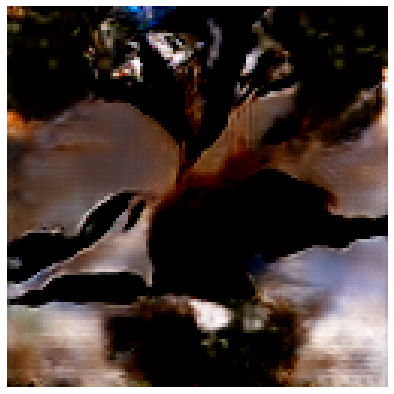

In [443]:
image = plt.figure(figsize=(7,7))
ax = image.add_subplot(1,1,1)
ax.imshow(fake_images[0][15])
ax.axis("off")